# Introduction to Photometry

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: Demonstrate photometry on a series of bias and flat field corrected images of a Near Earth Asteroid. 

## 0. Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

### 0.1 Directory Set up

In [2]:
datadir = '/Users/jrobinson/Google Drive/QUB PhD/LSST/Baltimore Jan 2018/PointSourcePhotometry_DF/'
objname  = '2016HO3'

### 0.2 Display images

In [3]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(numb))[0].data

    f = plt.figure(figsize=(10,12))
    #im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:580, 460:600], cmap='hot',origin='lower')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.034, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()
    
def plotfits_target(imno,cent1,cent2,cent3,cent4):
    print(datadir+objname+'_{0:02d}.fits'.format(imno))
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(imno))[0].data
    
    f = plt.figure(figsize=(10,12))
    #im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:580, 460:600], cmap='hot',origin='lower')
    plt.clim(1800, 2800)
    plt.scatter(cent1[1],cent1[0],marker='x',color='k')
    plt.scatter(cent2[1],cent2[0],marker='x',color='b')
    plt.scatter(cent3[1],cent3[0],marker='x',color='k')
    plt.scatter(cent4[1],cent4[0],marker='x',color='b')
    plt.colorbar(im, fraction=0.034, pad=0.04)
    plt.savefig("figure_target{0}.png".format(imno))
    plt.show()

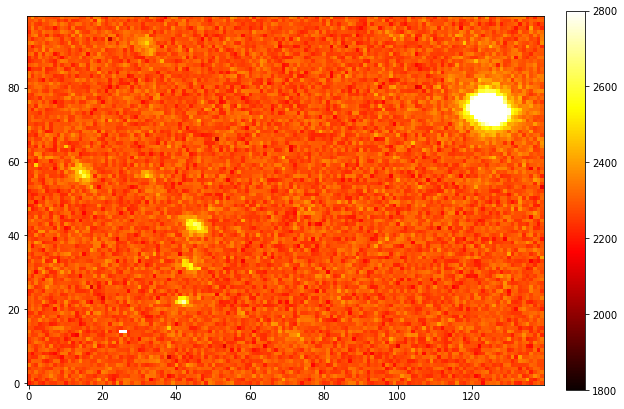

In [4]:
numb = 1 
plotfits(numb)

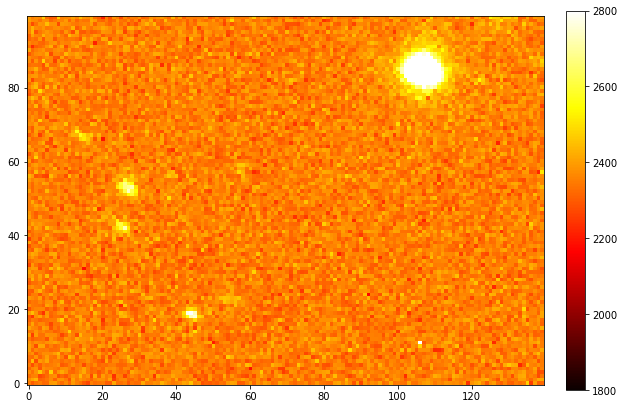

In [5]:
numb = 2
plotfits(numb)

## 1. Photometry set up

Select part of the image for ease of display.

In [6]:
partimg = fits.open(datadir+objname+'_01.fits')[0].data[480:580, 460:600]

Define starting values. Fill in values here:

In [7]:
targcen = np.array([20,40])  ## target center
compcen = np.array([80,120])  ## comparison center

Aperture photometry set up. Play around with adjusting the aperture radii sizes and see the resulting image under 'Tests'

In [8]:
searchr = 6  ## search box size
ap_r    = 2   ## aperture radius

sky_inner = 3
sky_outer = 5

### 1.1 Centroiding: Center of Mass

Calculate Center of Mass (CoM) defined as: $\bar{x} = \frac{\sum A_i x_i}{\sum A_i }$, $\bar{y} = \frac{\sum A_i  y_i}{\sum A_i }$.

In [9]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    cent=np.zeros((2),np.float)
    
    '''store=[]
    for j in range(len(psf[0,:])):
        store.append(np.sum(psf[:,j]*weights)/np.sum(psf[:,j]))
    cent[0]=np.mean(store)
    
    store=[]
    for i in range(len(psf[:,0])):
        store.append(np.sum(psf[i,:]*weights)/np.sum(psf[i,:]))
    cent[1]=np.mean(store)'''
    
    temp = sum(sum(psf) - min(sum(psf)))
    cent[1] = sum((sum(psf) - min(sum(psf))) * weights) / temp
    cent[0] = sum((sum(psf.T) - min(sum(psf.T))) * weights)/ temp
    
    return cent

Use centroiding algorithm to find the actual centers of the targe and comparison.

In [10]:
## Cut a box between search limits, centered around targcen
targbox = partimg[targcen[0]-searchr : targcen[0]+searchr, targcen[1]-searchr : targcen[1]+searchr]
weights = cent_weight(len(targbox))
#print(weights)
tcenoffset = calc_CoM(targbox, weights)
#print(tcenoffset)
tcenter = targcen + tcenoffset
#print(np.sqrt(tcenoffset[0]**2.0+tcenoffset[1]**2.0))
print(tcenter)

[21.38789261 41.48846709]


In [11]:
compbox = partimg[compcen[0]-searchr : compcen[0]+searchr, compcen[1]-searchr : compcen[1]+searchr]
weights = cent_weight(len(compbox))
ccenoffset = calc_CoM(compbox, weights)
ccenter = compcen + ccenoffset
print(ccenter)

[ 75.40451137 124.26057251]


Inspect PSF to see whether shift makes sense

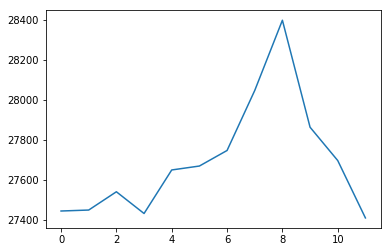

In [12]:
plt.plot(sum(targbox))
plt.show()

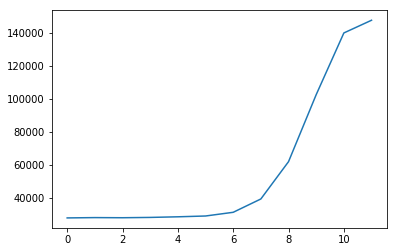

In [13]:
plt.plot(sum(compbox))
plt.show()

/Users/jrobinson/Google Drive/QUB PhD/LSST/Baltimore Jan 2018/PointSourcePhotometry_DF/2016HO3_01.fits


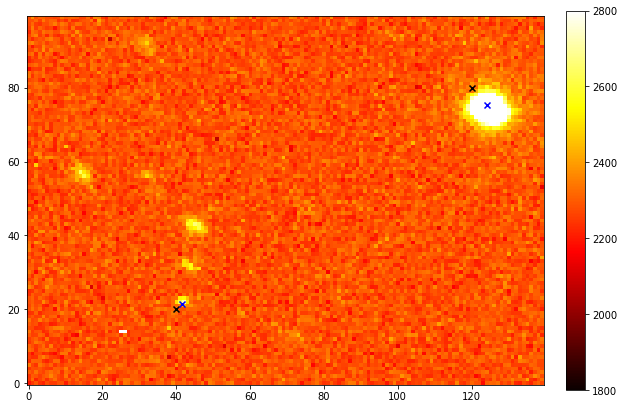

In [14]:
plotfits_target(1,targcen,tcenter,compcen,ccenter)

In [15]:
compbox = partimg[compcen[0]-searchr : compcen[0]+searchr, compcen[1]-searchr : compcen[1]+searchr]
compw = cent_weight(len(compbox))
ccenoffset = calc_CoM(compbox,compw)
ccenter = compcen + ccenoffset

In [16]:
print(tcenter)

[21.38789261 41.48846709]


In [17]:
compw

array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,
        5.5])

### 1.2 Aperture Photometry

#### Science Aperture

In [18]:
def circle(npix, r1):
    """
    Builds a circle
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            r=np.sqrt((float(i-npix/2)+0.5)**2+(float(j-npix/2)+0.5)**2)
            if r<=r1:
                pup[i,j]=1
    return pup

#### Sky annulus

In [19]:
def annulus(npix, r_inner,r_outer=-1.):
    """
    Builds an annulus
    """
    pup=np.zeros((npix,npix),np.int)
    for i in range(npix):
        for j in range(npix):
            #### Fill in annulus form here ####
            if ((r<=r_outer)&(r>=r_inner)):
                pup[i,j]=1
    return pup

#### Extract values from regions

Create mask

In [20]:
circmask = circle(searchr*2, ap_r)
annmask = annulus(searchr*2, sky_inner, sky_outer)

NameError: name 'r' is not defined

Define new regions where the target and comparison are centered.

In [21]:
newtarg = partimg[int(round(tcenter[0]))-searchr : int(round(tcenter[0]))+searchr, int(round(tcenter[1]))-searchr : int(round(tcenter[1]))+searchr]
newcomp = partimg[int(round(ccenter[0]))-searchr : int(round(ccenter[0]))+searchr, int(round(ccenter[1]))-searchr : int(round(ccenter[1]))+searchr]

Place mask on region

In [22]:
targaper = newtarg * circmask
compaper = newcomp * circmask

Place mask on sky annulus slice. 

In [23]:
targann = newtarg * annmask
compann = newcomp * annmask

NameError: name 'annmask' is not defined

### 1.3 Tests

a. Display image with target and comparison centers before and after centroiding

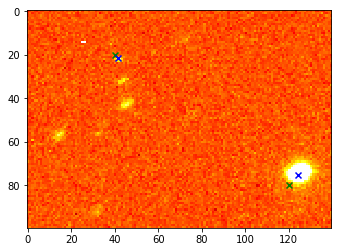

In [24]:
im = plt.imshow(partimg, cmap='hot')
plt.clim(1800, 2800)
plt.scatter(targcen[1], targcen[0], c='g', marker='x')
plt.scatter(compcen[1], compcen[0], c='g', marker='x')
plt.scatter(tcenter[1], tcenter[0], c='b', marker='x')
plt.scatter(ccenter[1], ccenter[0], c='b', marker='x')
plt.show()

b. Disply image with aperture mask and sky annulus

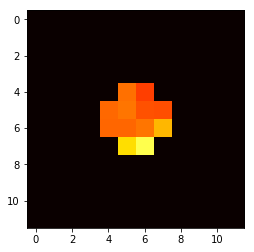

In [25]:
im = plt.imshow(targaper, cmap='hot')
plt.clim(1800, 2800)
plt.show()

In [ ]:
im = plt.imshow(targann, cmap='hot')
plt.clim(1800, 2800)
plt.show()

## 2. Photometry

### 2.1 Calculate SNR

Calculate Signal-to-Noise Ratio. CCD noise = sqrt(signal + background + dark current + read noise). Ignore dark current and read noise here. 

In [ ]:
def calcsnr(target, bg):
    signal = target - bg
    noise = np.sqrt(signal + bg)
    snr = signal / noise
    return snr, noise   

Sum all flux inside target and comparison apertures and divide by number of pixels to get average count per pixel.

In [ ]:
targc = np.sum(targaper) / np.sum(circmask)
targbg= np.sum(targann) /  np.sum(annmask)
compc = np.sum(compaper) /  np.sum(circmask)
compbg= np.sum(compann) /  np.sum(annmask)

In [ ]:
snr, noise = calcsnr(targc, targbg)
print(snr)

In [ ]:
snr, noise = calcsnr(compc, compbg)
print(snr)

### 2.2 Optimize photometry aperture

In [ ]:
## Write code here that tries a range of photometry apertures and finds the best SNR ##

In [ ]:
print(bestaper)
print(snr)

### 2.3 Calculate the target's magnitude and uncertainty


Given the comparison is of known magnitude of 19.4

In [ ]:
targc = circle(searchr*2, ap_r)*newtarg
targskyc = annulus(searchr*2, sky_inner, sky_outer)*newtarg
compc = circle(searchr*2, ap_r)*newcomp
compskyc = annulus(searchr*2, sky_inner, sky_outer)*newcomp

ratio = np.sum(compc)/np.sum(targc)
### complete here ###
### complete here ###
### complete here ###

refmag = 19.4
### complete here ###
print("Measured Magnitude = {:0.3f} ± {:0.3f}".format(mag, sigmamag))

# Further Exercises

a. Perform photometry on all 10 images of the asteroid and find its period of rotation.

b. Perform photometry using Gaussian PSF fitting. 